In [1]:
import sys, time
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import Axes3D
import numpy as np

from pykern import pkcli
from pykern.pkcollections import PKDict

# The rslaser library may not be installed, so a check is required.
try:
    import rslaser
except:
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
    !{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
    import rslaser
from rslaser.elements import drift, crystalSlice
from rslaser.rspulse import pulse

import scipy.constants as const

# reset the notebook style
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

In [2]:
"""CalcIntFromElecField(_arI, _inWfr, _inPol, _inIntType, _inDepType, _inE, _inX, _inY)
function calculates/"extracts" Intensity from pre-calculated Electric Field
:param _arI: output resulting Intensity array (should be allocated in Python script before calling this function)
:param _inWfr: input pre-calculated Wavefront structure (instance of SRWLWfr)
:param _inPol: input switch specifying polarization component to be extracted:
               =0 -Linear Horizontal; 
               =1 -Linear Vertical; 
               =2 -Linear 45 degrees; 
               =3 -Linear 135 degrees;
               =4 -Circular Right; 
               =5 -Circular Left; 
               =6 -Total
:param _inIntType: input switch specifying "type" of a characteristic to be extracted:
               =0 -"Single-Electron" Intensity; 
               =1 -"Multi-Electron" Intensity; 
               =2 -"Single-Electron" Flux; 
               =3 -"Multi-Electron" Flux; 
               =4 -"Single-Electron" Radiation Phase; NOTE: requires DOUBLE PRECISION array via srwlib.array('d', ...)
               =5 -Re(E): Real part of Single-Electron Electric Field;
               =6 -Im(E): Imaginary part of Single-Electron Electric Field;
               =7 -"Single-Electron" Intensity, integrated over Time or Photon Energy (i.e. Fluence)
               =8 -"Single-Electron" Mutual Intensity (i.e. E(r)E*(r')) 
:param _inDepType: input switch specifying type of dependence to be extracted:
               =0 -vs e (photon energy or time);
               =1 -vs x (horizontal position or angle);
               =2 -vs y (vertical position or angle);
               =3 -vs x&y (horizontal and vertical positions or angles);
               =4 -vs e&x (photon energy or time and horizontal position or angle);
               =5 -vs e&y (photon energy or time and vertical position or angle);
               =6 -vs e&x&y (photon energy or time, horizontal and vertical positions or angles);
:param _inE: input photon energy [eV] or time [s] to keep fixed (to be taken into account for dependences vs x, y, x&y)
:param _inX: input horizontal position [m] to keep fixed (to be taken into account for dependences vs e, y, e&y)
:param _inY: input vertical position [m] to keep fixed (to be taken into account for dependences vs e, x, e&x)
"""
import srwlib
from srwlib import srwl

In [3]:
# define a simple lattice
dr1 = drift.drift('dr1', 0.2)                      # 20 cm drift
crystal = crystalSlice.crystalSlice('cryst_slice1', 0.1)  # 10 cm single-slice crystal 
dr2 = drift.drift('dr2', 0.02)                     #  2 cm drift
lattice = [(dr1,'default'), (crystal,'abcd'), (dr2,'default')]
  
current_position = 0.0 
print('Initial z position of the pulse:', current_position, 'm')

Initial z position of the pulse: 0.0 m


In [4]:
# specify the parameters in a PKDict dictionary object
_Z_WAIST_DEFAULT = 0
_Z_CENTER_DEFAULT = 0
_LASER_PULSE_SLICE_DEFAULTS = PKDict(
    sigrW=0.000186,
    propLen=15,
    pulseE=0.001,
    poltype=1,
    sampFact=5,
    numsig=3.,
    mx=0,
    my=0
)
_LASER_PULSE_DEFAULTS = PKDict(
        phE=1.55,
        nslice=3,
        chirp=0,
        w0=.1,
        a0=.01,
        dw0x=0.0,
        dw0y=0.0,
        z_waist=0.,
        dzwx=0.0,
        dzwy=0.0,
        tau_fwhm=2.e-10,
        z_center=0.,
        x_shift = 0.,
        y_shift=0.,
        d_to_w=_Z_WAIST_DEFAULT - _Z_CENTER_DEFAULT,
        slice_params=_LASER_PULSE_SLICE_DEFAULTS,
)

In [5]:
# Override some of the default parameters
# First, instantiate the default parameters:
params = _LASER_PULSE_DEFAULTS.copy()

lambda0 = 8.e-7                     # wavelength [m]
phE = const.h * const.c / lambda0   # photon energy [J]
phE_ev = phE / const.e              # photon energy [eV]
print(' photon energy = {0:4.2E} [J]'.format(phE) + ' = {0:4.2f} [eV]'.format(phE_ev))

print(' params.tau_fwhm = {0:4.2E} [s]'.format(params.tau_fwhm))
tau_fwhm = 0.3e-13                  # FWHM pulse length [s]
params.tau_fwhm = tau_fwhm

w0 = 400.e-6                        # waist size [m]
params.w0 = w0
params.d_to_w = 0.01  #  [m] distance from the initial pulse location to the loc-n of the beam waist, > 0 if converging 
params.nslice = 1  #  the number of slices the pulse is divided into 

params.slice_params.propLen = 15.0  # [m] 
params.slice_params.sigrW = 0.000186  # 0.000436984 #  radial rms size at the waist [m] 
params.slice_params.pulseE = 0.001  # pulse energy [J] 
params.slice_params.poltype = 1  #  0 = linear horizontal, 1 = linear vertical, ... 

 photon energy = 2.48E-19 [J] = 1.55 [eV]
 params.tau_fwhm = 2.00E-10 [s]


In [6]:
# Instantiate the laser pulse
thisPulse = pulse.LaserPulse(params)

In [10]:
# initial pulse - intensity

# choose one of the laser pulse slices, and grab its SRW wavefront object
slice_array=thisPulse.slice
slice_number = 0
wfr0=slice_array[slice_number].wfr

arIinit = srwlib.array('f', [0]*wfr0.mesh.nx*wfr0.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arIinit, wfr0, 0, 0, 3, wfr0.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
arIinit2D = np.array(arIinit).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
wfrsizei=np.size(arIinit)

print('Size of initial wavefront data array (coordinate):',np.shape(arIinit2D))
xvalsf02=np.linspace(wfr0.mesh.xStart,wfr0.mesh.xFin,wfr0.mesh.nx)
yvalsf02=np.linspace(wfr0.mesh.yStart,wfr0.mesh.yFin,wfr0.mesh.ny)


Size of initial wavefront data array (coordinate): (1664, 1664)


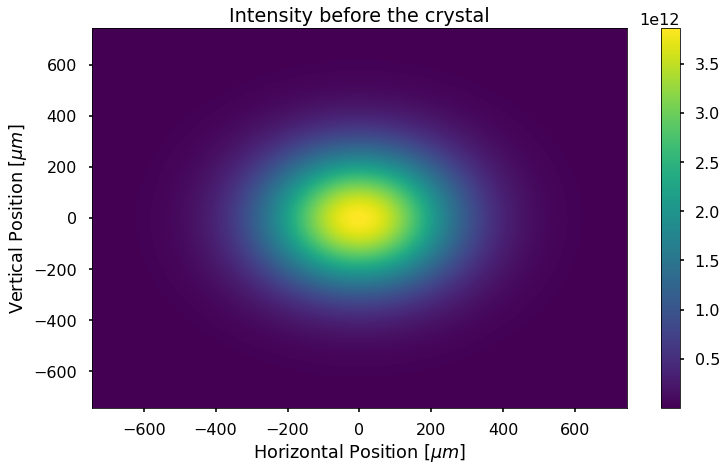

In [11]:
# plot the computed intensity

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(12,7))
    ax = fig.gca()

    # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
    plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), arIinit2D, cmap=plt.cm.viridis,shading='auto')
    plt.colorbar()
    #['Horizontal Position [mm]', , 'Intensity']
    ax.set_ylabel(r'Vertical Position [$\mu m$]')
    ax.set_xlabel(r'Horizontal Position [$\mu m$]')
    ax.set_title('Intensity before the crystal')

In [13]:
# initial pulse - phase
wfr1=slice_array[slice_number].wfr

brIinit = srwlib.array('d', [0]*wfr1.mesh.nx*wfr1.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(brIinit, wfr1, 0, 4, 3, wfr1.mesh.eStart, 0, 0) #extracts the phase; must use double precision

##Reshaping electric field data from flat to 2D array
brIinit2D = np.array(brIinit).reshape((wfr1.mesh.nx, wfr1.mesh.ny), order='C')
wfrsize=np.size(brIinit)

print('Size of initial wavefront data array (coordinate):',np.shape(brIinit2D))
xvalsf02=np.linspace(wfr1.mesh.xStart,wfr1.mesh.xFin,wfr1.mesh.nx)
yvalsf02=np.linspace(wfr1.mesh.yStart,wfr1.mesh.yFin,wfr1.mesh.ny)

Size of initial wavefront data array (coordinate): (1664, 1664)


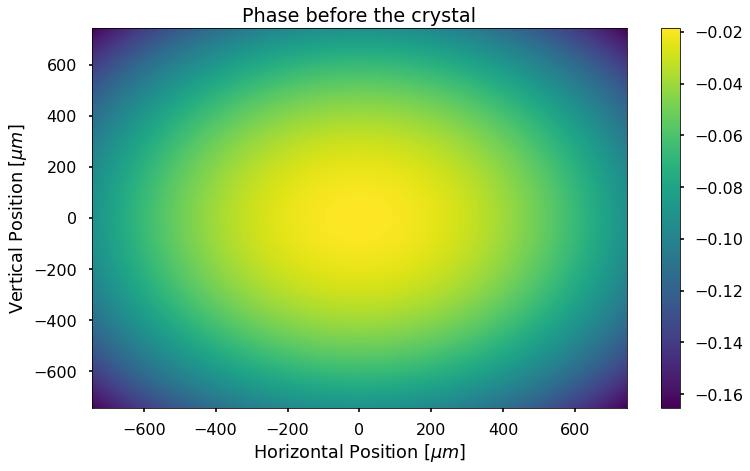

In [14]:
# plot the phase

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(12,7))
    ax = fig.gca()

    # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
    plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), brIinit2D, cmap=plt.cm.viridis,shading='auto')
    plt.colorbar()
    #['Horizontal Position [mm]', , 'Phase']
    ax.set_ylabel(r'Vertical Position [$\mu m$]')
    ax.set_xlabel(r'Horizontal Position [$\mu m$]')
    ax.set_title('Phase before the crystal')

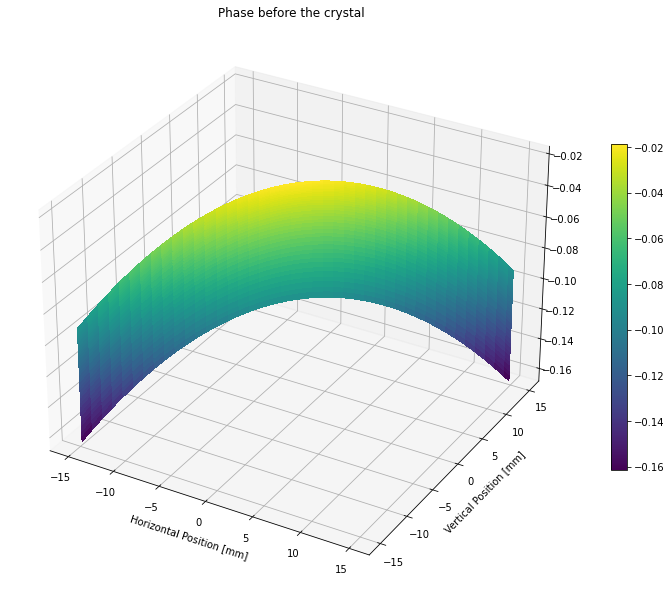

In [15]:
# plot the phase in 3D
fig = plt.figure(figsize=(28,12))
# here, `ax` is a 3D-aware axis instance because of the projection='3d' keyword
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_ylabel(r'Vertical Position [mm]')
ax.set_xlabel(r'Horizontal Position [mm]')
ax.set_title('Phase before the crystal')
p = ax.plot_surface(2.*np.multiply(xvalsf02,1e4), 2.*np.multiply(yvalsf02,1e4), brIinit2D, 
                    rstride=40, cstride=40, cmap=plt.cm.viridis, linewidth=0, antialiased=False)
cb = fig.colorbar(p, shrink=0.5)

In [16]:
#  Propagate the pulse through the optical beamline: 
for i in lattice:
    current_elem, prop_type = i 
    # print (current_elem, prop_type) 
    thisPulse = current_elem.propagate(thisPulse, prop_type)
    current_position += current_elem.length
    print('Current position in the beamline:', current_position, ' m')

Current position in the beamline: 0.2  m
Propagated pulse slice  1  of  1
Current position in the beamline: 0.30000000000000004  m
Current position in the beamline: 0.32000000000000006  m


In [17]:
# transmitted pulse - intensity
wfr2=slice_array[slice_number].wfr

arIinit = srwlib.array('f', [0]*wfr2.mesh.nx*wfr2.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arIinit, wfr2, 0, 0, 3, wfr0.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
arIinit2D = np.array(arIinit).reshape((wfr2.mesh.nx, wfr2.mesh.ny), order='C')
wfrsizei=np.size(arIinit)

print('Size of initial wavefront data array (coordinate):',np.shape(arIinit2D))
xvalsf02=np.linspace(wfr2.mesh.xStart,wfr2.mesh.xFin,wfr2.mesh.nx)
yvalsf02=np.linspace(wfr2.mesh.yStart,wfr2.mesh.yFin,wfr2.mesh.ny)

Size of initial wavefront data array (coordinate): (1664, 1664)


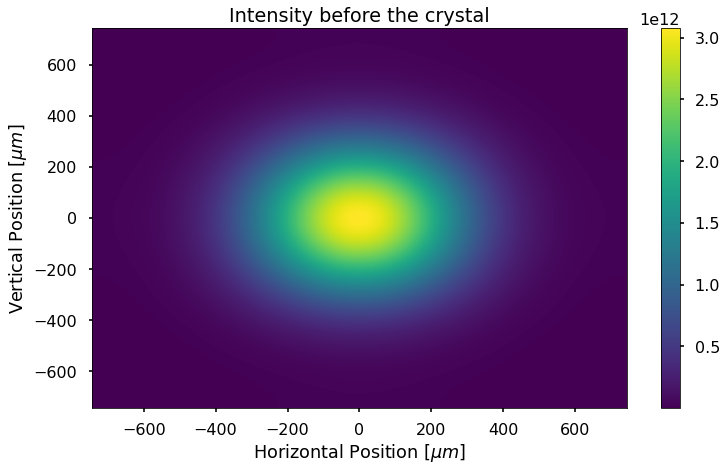

In [18]:
# plot the computed intensity

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(12,7))
    ax = fig.gca()

    # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
    plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), arIinit2D, cmap=plt.cm.viridis,shading='auto')
    plt.colorbar()
    #['Horizontal Position [mm]', , 'Intensity']
    ax.set_ylabel(r'Vertical Position [$\mu m$]')
    ax.set_xlabel(r'Horizontal Position [$\mu m$]')
    ax.set_title('Intensity before the crystal')

In [20]:
# transmitted pulse - phase
wfr3=slice_array[slice_number].wfr

brIinit = srwlib.array('d', [0]*wfr3.mesh.nx*wfr3.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(brIinit, wfr3, 0, 4, 3, wfr3.mesh.eStart, 0, 0) #extracts the phase; must use double precision

##Reshaping electric field data from flat to 2D array
brIinit2D = np.array(brIinit).reshape((wfr3.mesh.nx, wfr3.mesh.ny), order='C')
wfrsize=np.size(brIinit)

print('Size of initial wavefront data array (coordinate):',np.shape(brIinit2D))
xvalsf02=np.linspace(wfr3.mesh.xStart,wfr3.mesh.xFin,wfr3.mesh.nx)
yvalsf02=np.linspace(wfr3.mesh.yStart,wfr3.mesh.yFin,wfr3.mesh.ny)

Size of initial wavefront data array (coordinate): (1664, 1664)


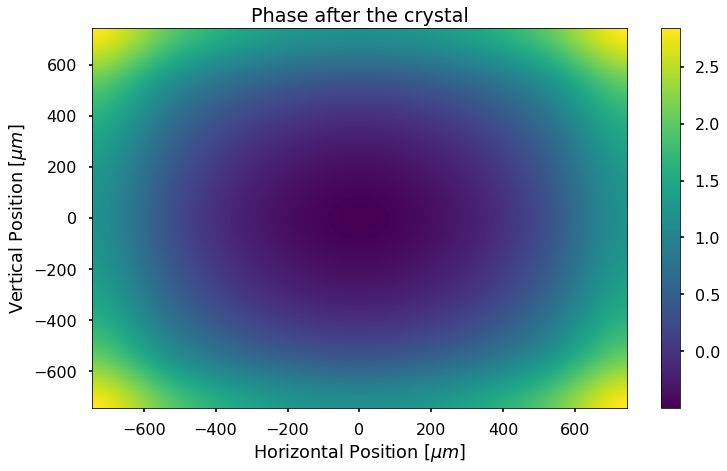

In [21]:
# plot the phase

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(12,7))
    ax = fig.gca()

    # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
    plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), brIinit2D, cmap=plt.cm.viridis,shading='auto')
    plt.colorbar()
    #['Horizontal Position [mm]', , 'Phase']
    ax.set_ylabel(r'Vertical Position [$\mu m$]')
    ax.set_xlabel(r'Horizontal Position [$\mu m$]')
    ax.set_title('Phase after the crystal')

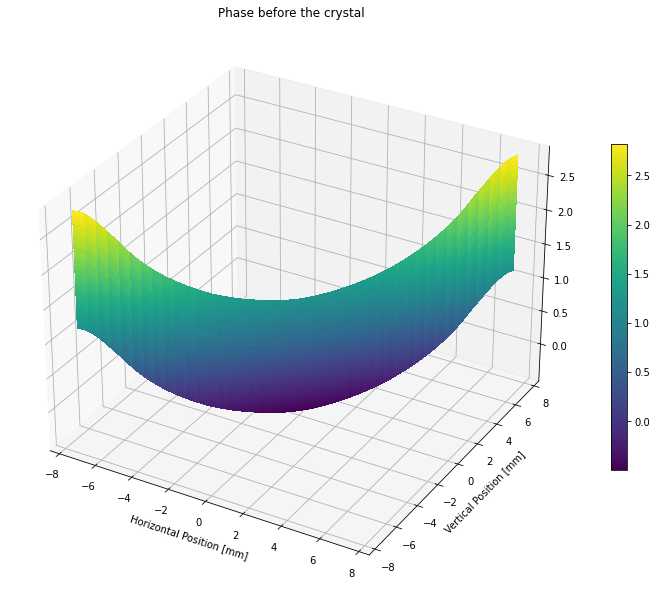

In [22]:
# plot the phase in 3D
fig = plt.figure(figsize=(28,12))
# here, `ax` is a 3D-aware axis instance because of the projection='3d' keyword
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_ylabel(r'Vertical Position [mm]')
ax.set_xlabel(r'Horizontal Position [mm]')
ax.set_title('Phase before the crystal')
p = ax.plot_surface(np.multiply(xvalsf02,1e4), np.multiply(yvalsf02,1e4), brIinit2D, 
                    rstride=40, cstride=40, cmap=plt.cm.viridis, linewidth=0, antialiased=False)
cb = fig.colorbar(p, shrink=0.5)